In [59]:
library("readr")
library("readxl")
library("ggplot2")
library("car")
library("foreign")
library(lattice)
library(gplots)
library(plm)
library(lmtest)
library(dplyr)
library(sandwich)


In [60]:
Panel <- read_excel("C:/Users/readytouse/Desktop/Magistrale/banking/project_3/panel_dataset.xlsx")
head(Panel)
tail(Panel)

DATE,Country,Corp_IR,HH_IR,DFR,MRO,MLF
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2005-01-31,Austria,3.46,3.78,1,2,3
2005-02-28,Austria,3.50,3.60,1,2,3
2005-03-31,Austria,3.50,3.59,1,2,3
2005-04-30,Austria,3.50,3.47,1,2,3
2005-05-31,Austria,3.47,3.54,1,2,3
2005-06-30,Austria,3.44,3.52,1,2,3


DATE,Country,Corp_IR,HH_IR,DFR,MRO,MLF
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2023-07-31,high_dev,4.78125,3.91250,3.50,4.00,4.25
2023-08-31,high_dev,4.83375,3.95500,3.74,4.24,4.49
2023-09-30,high_dev,4.99750,4.00875,3.84,4.34,4.59
2023-10-31,high_dev,5.06375,4.04000,4.00,4.50,4.75
2023-11-30,high_dev,5.10875,4.11250,4.00,4.50,4.75
2023-12-31,high_dev,5.13000,4.09625,4.00,4.50,4.75


#### Exploring Panel Data

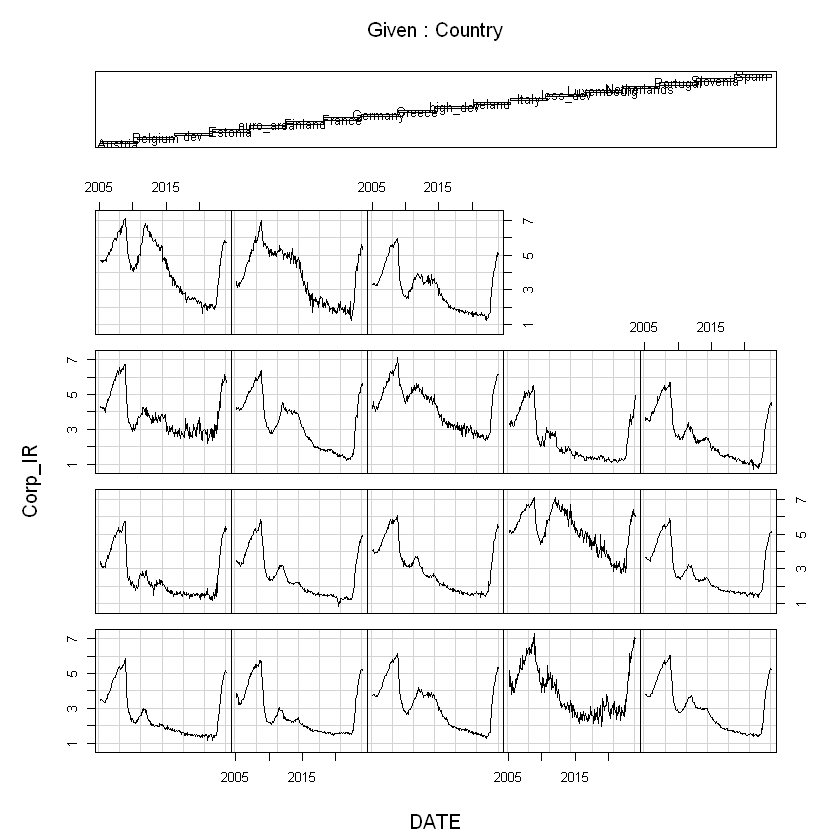

In [61]:
coplot(Corp_IR ~ DATE|Country, type="l", data=Panel) 

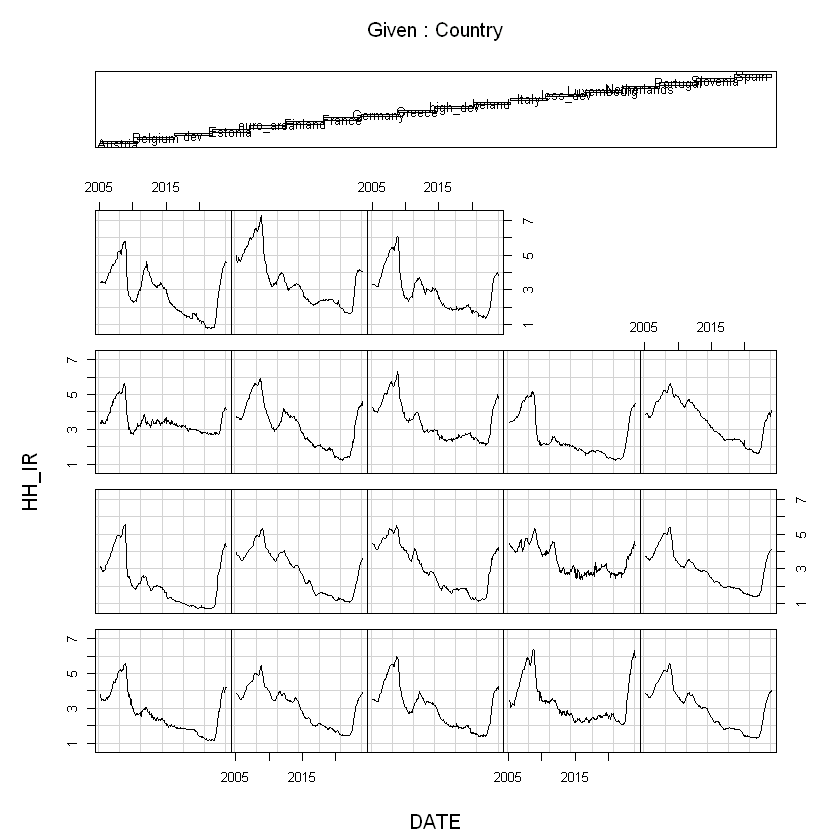

In [62]:
coplot(HH_IR ~ DATE|Country, type="l", data=Panel) 

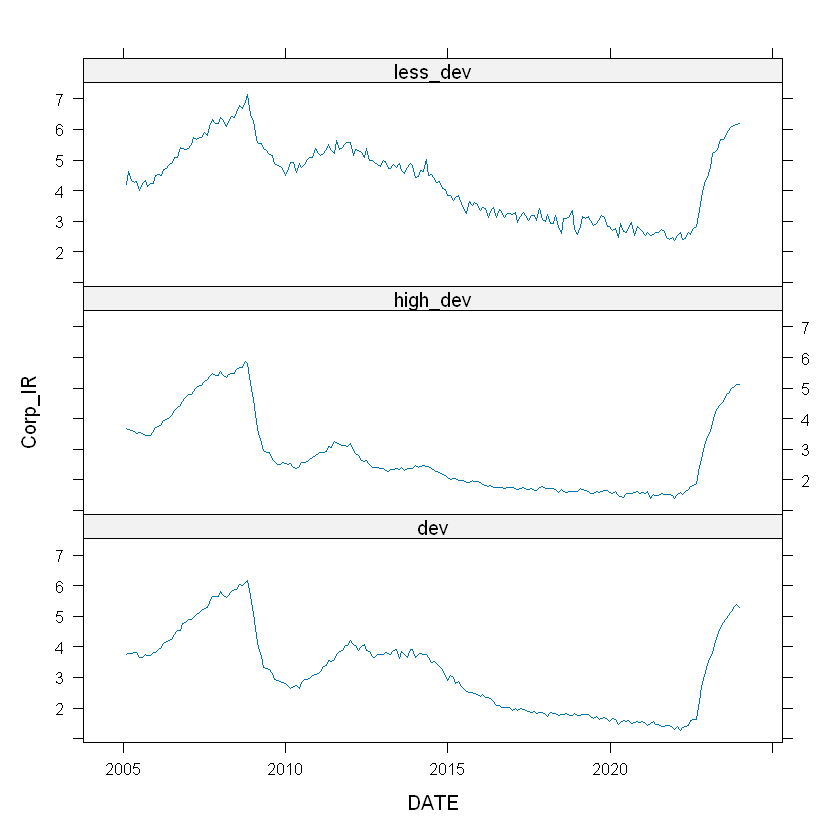

In [63]:
xyplot(Corp_IR ~ DATE | Country, 
       data = subset(Panel, Country %in% c("less_dev", "dev", "high_dev")),
       type = "l",  # "p" = points only
       layout = c(1, 3))  # 1 column, 3 rows (optional)


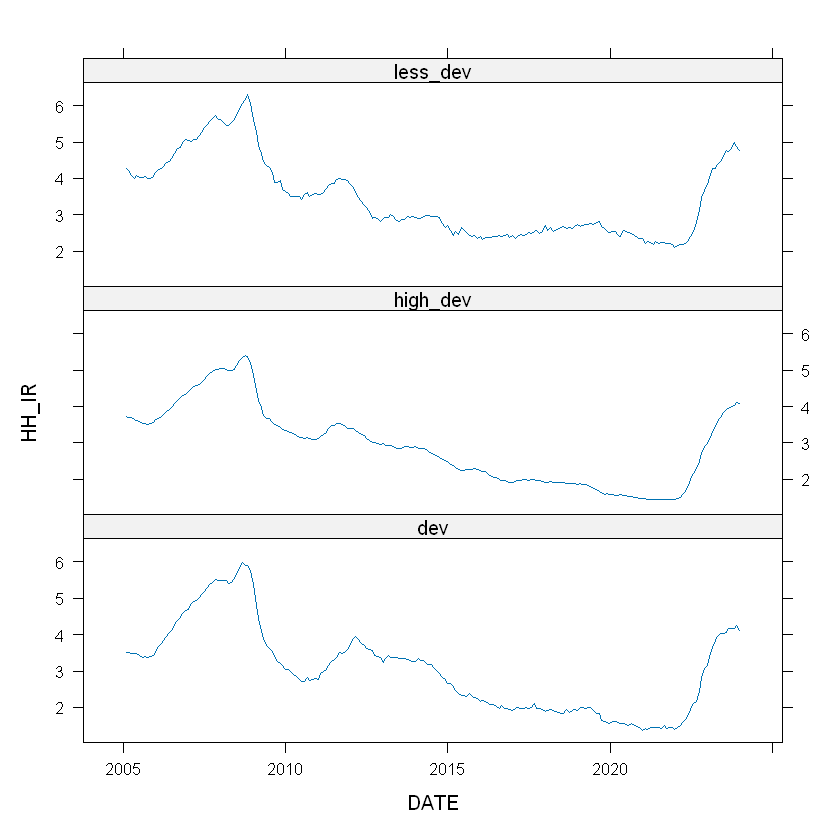

In [64]:
xyplot(HH_IR ~ DATE | Country, 
       data = subset(Panel, Country %in% c("less_dev", "dev", "high_dev")),
       type = "l",
      layout = c(1, 3))  # "p" = points only
         # 1 column, 3 rows (optional)


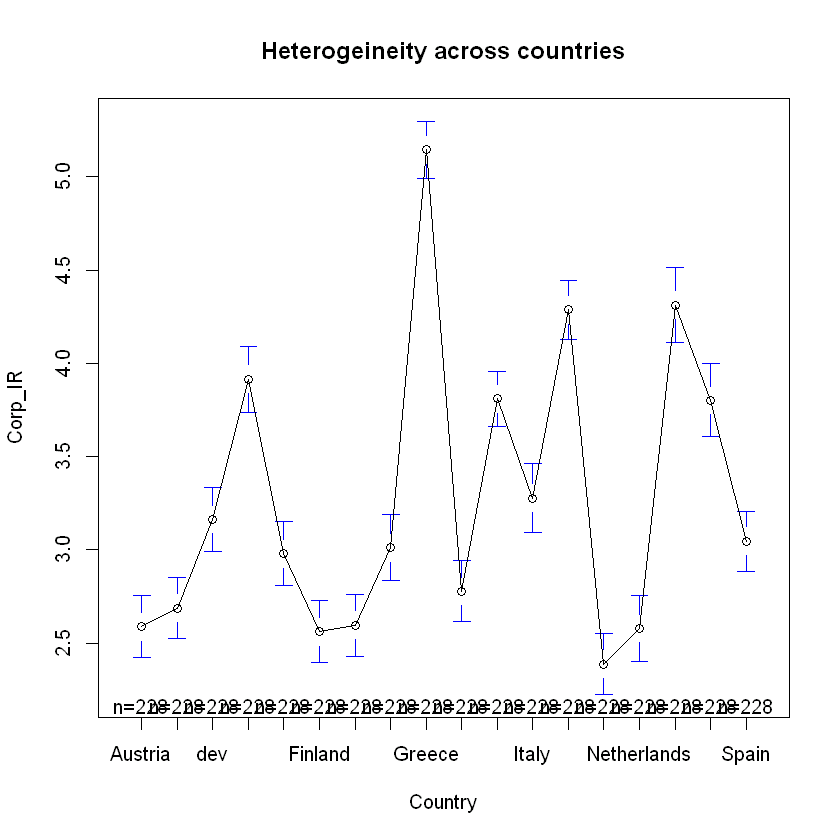

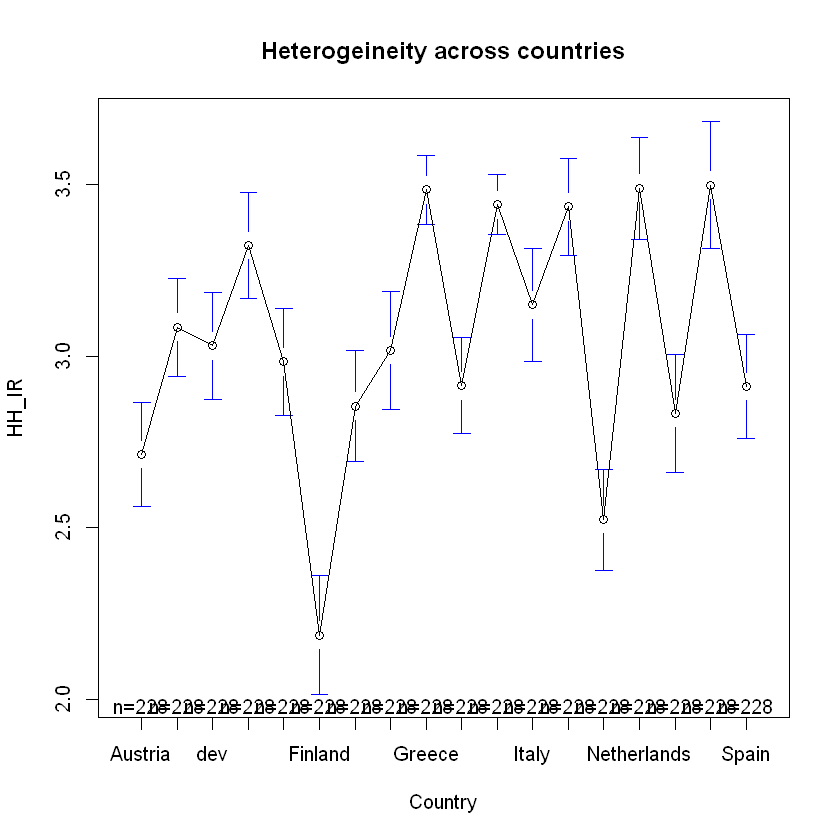

In [65]:
# heterogeneity across countries

plotmeans(Corp_IR ~ Country, main="Heterogeineity across countries", data=Panel)
plotmeans(HH_IR ~ Country, main="Heterogeineity across countries", data=Panel)


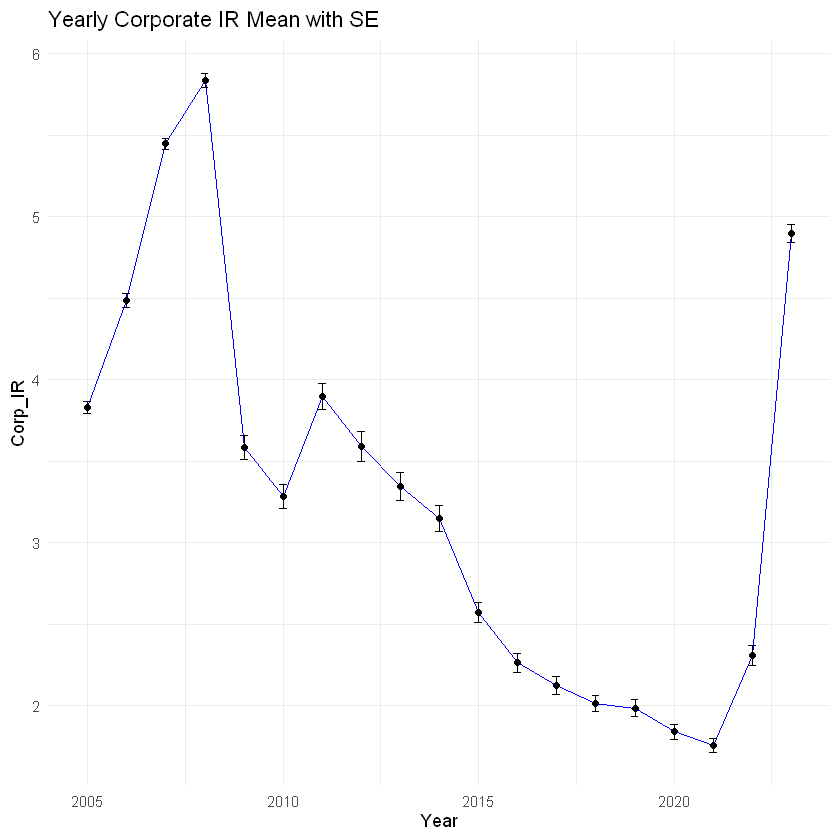

In [66]:
# heterogeneity across years for CORPORATIONS

Panel$Year <- format(as.Date(Panel$DATE), "%Y")   # we aggregate for year using the mean in order to have better readability of the plot

year_summary <- Panel %>%
  group_by(Year) %>%
  summarise(
    Corp_IR_mean = mean(Corp_IR, na.rm = TRUE),
    Corp_IR_sd = sd(Corp_IR, na.rm = TRUE),
    n = n(),
    se = Corp_IR_sd / sqrt(n)
  )

# Plot with error bars
ggplot(year_summary, aes(x = as.numeric(Year), y = Corp_IR_mean)) +
  geom_line(color = "blue") +
  geom_point() +
  geom_errorbar(aes(ymin = Corp_IR_mean - se, ymax = Corp_IR_mean + se), width = 0.2) +
  labs(title = "Yearly Corporate IR Mean with SE", x = "Year", y = "Corp_IR") +
  theme_minimal()

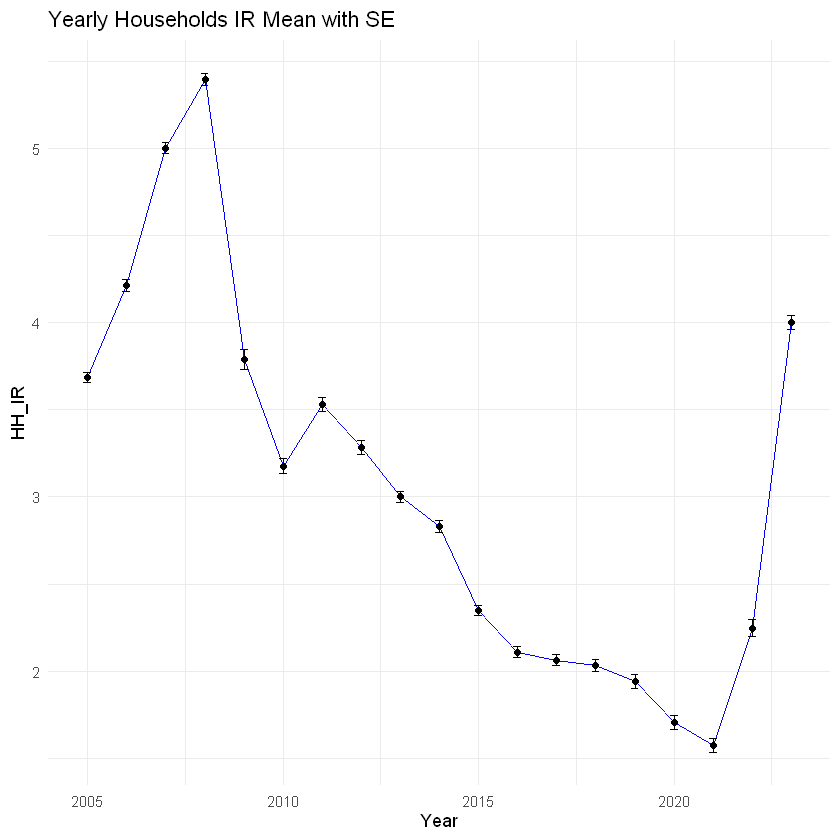

In [67]:
# heterogeneity across years for HOUSEHOLDS

Panel$Year <- format(as.Date(Panel$DATE), "%Y")   # we aggregate for year using the mean in order to have better readability of the plot

year_summary <- Panel %>%
  group_by(Year) %>%
  summarise(
    HH_IR_mean = mean(HH_IR, na.rm = TRUE),
    HH_IR_sd = sd(HH_IR, na.rm = TRUE),
    n = n(),
    se = HH_IR_sd / sqrt(n)
  )

# Plot with error bars
ggplot(year_summary, aes(x = as.numeric(Year), y = HH_IR_mean)) +
  geom_line(color = "blue") +
  geom_point() +
  geom_errorbar(aes(ymin = HH_IR_mean - se, ymax = HH_IR_mean + se), width = 0.2) +
  labs(title = "Yearly Households IR Mean with SE", x = "Year", y = "HH_IR") +
  theme_minimal()

### Pooled regression 

In [68]:
# regular OLS regression -> pooled model

#IMP: doesn't consider heterogeneity among groups and time

pooled_reg_corp <- lm(Corp_IR ~ MRO, data = Panel)
summary(pooled_reg_corp)

pooled_reg_HH <-lm(HH_IR ~ MRO, data = Panel)
summary(pooled_reg_HH)


Call:
lm(formula = Corp_IR ~ MRO, data = Panel)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1507 -0.6846 -0.3016  0.4436  4.1898 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.31335    0.01934  119.61   <2e-16 ***
MRO          0.82720    0.01060   78.03   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9556 on 4102 degrees of freedom
Multiple R-squared:  0.5975,	Adjusted R-squared:  0.5974 
F-statistic:  6088 on 1 and 4102 DF,  p-value: < 2.2e-16



Call:
lm(formula = HH_IR ~ MRO, data = Panel)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0183 -0.4438 -0.0107  0.4787  2.4320 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.213831   0.013577  163.06   <2e-16 ***
MRO         0.718432   0.007442   96.54   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6708 on 4102 degrees of freedom
Multiple R-squared:  0.6944,	Adjusted R-squared:  0.6943 
F-statistic:  9319 on 1 and 4102 DF,  p-value: < 2.2e-16


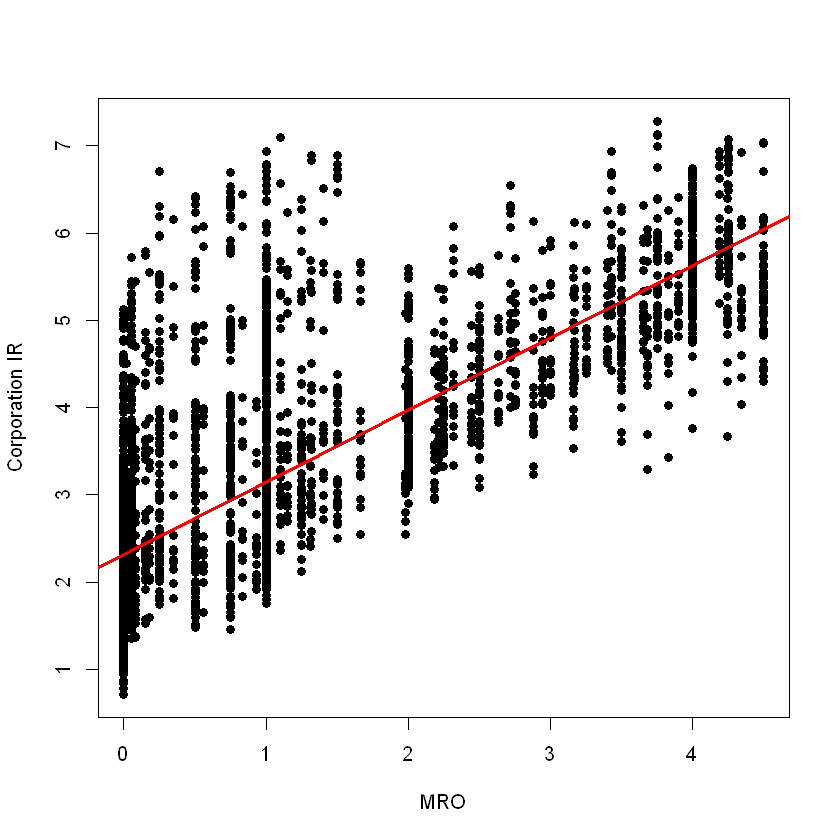

In [69]:
plot(Panel$MRO, Panel$Corp_IR, pch=19, xlab = "MRO", ylab="Corporation IR")
abline(lm(Panel$Corp_IR ~ Panel$MRO), lwd = 3, col = "red")

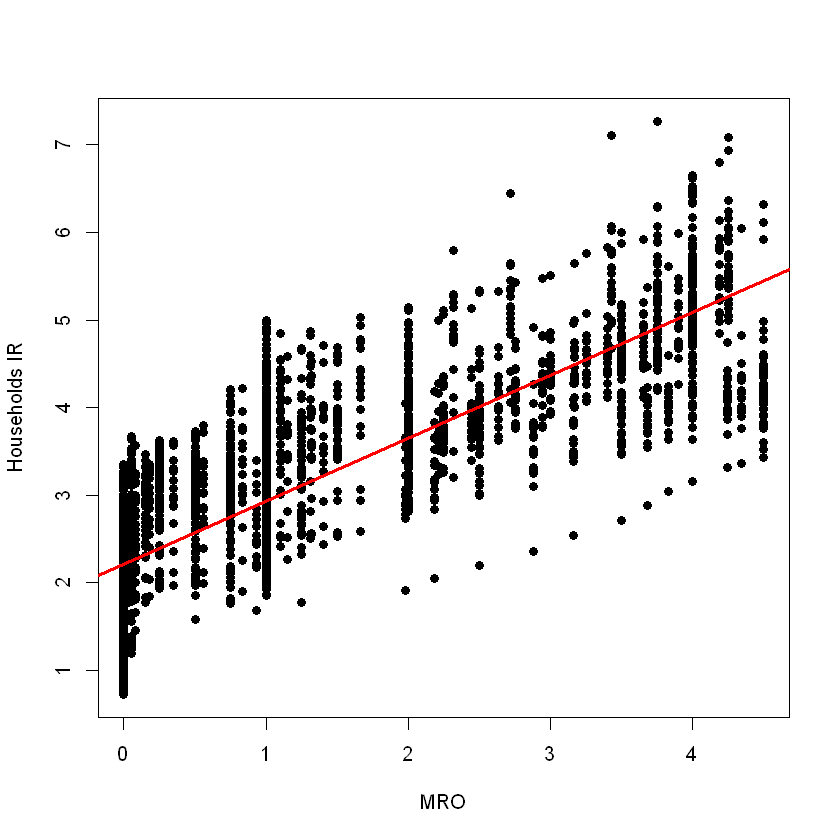

In [70]:
plot(Panel$MRO, Panel$HH_IR, pch=19, xlab = "MRO", ylab="Households IR")
abline(lm(Panel$HH_IR ~ Panel$MRO), lwd = 3, col = "red")

## Fixed effect model

In [71]:
# Declare the panel structure
pdata <- pdata.frame(Panel, index = c("Country", "DATE"))
head(pdata)


,DATE,Country,Corp_IR,HH_IR,DFR,MRO,MLF,Year
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Austria-2005-01-31,2005-01-31,Austria,3.46,3.78,1,2,3,2005
Austria-2005-02-28,2005-02-28,Austria,3.50,3.60,1,2,3,2005
Austria-2005-03-31,2005-03-31,Austria,3.50,3.59,1,2,3,2005
Austria-2005-04-30,2005-04-30,Austria,3.50,3.47,1,2,3,2005
Austria-2005-05-31,2005-05-31,Austria,3.47,3.54,1,2,3,2005
Austria-2005-06-30,2005-06-30,Austria,3.44,3.52,1,2,3,2005


#### FEM for Corporation

In [72]:
# fixed effects for country and for date for CORPORATION
fem1_Corp <- plm(Corp_IR ~ MRO, data = pdata, index = c("Country", "DATE"), model = "within")
summary(fem1_Corp)

Oneway (individual) effect Within Model

Call:
plm(formula = Corp_IR ~ MRO, data = pdata, model = "within", 
    index = c("Country", "DATE"))

Balanced Panel: n = 18, T = 228, N = 4104

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-1.876908 -0.350159 -0.055279  0.275185  2.520516 

Coefficients:
     Estimate Std. Error t-value  Pr(>|t|)    
MRO 0.8271965  0.0065957  125.41 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    7003.6
Residual Sum of Squares: 1443.9
R-Squared:      0.79383
Adj. R-Squared: 0.79292
F-statistic: 15728.9 on 1 and 4085 DF, p-value: < 2.22e-16

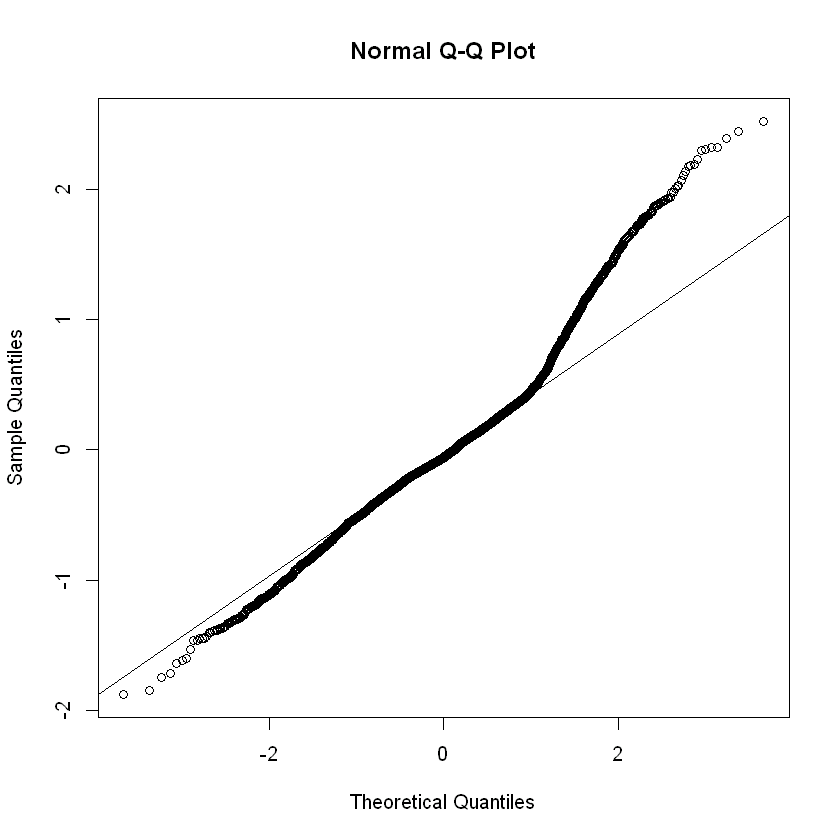

In [73]:
# check for normality of the errors

qqnorm(residuals(fem1_Corp))
qqline(residuals(fem1_Corp))

In [74]:
# understand why there is no normality

# check for autocorrelation

bgtest(fem1_Corp, order = 1)
bgtest(fem1_Corp, order = 2)
bgtest(fem1_Corp, order = 3)  

# small p-values for all orders so I refuse H0 and I assume autocorrelation


	Breusch-Godfrey test for serial correlation of order up to 1

data:  fem1_Corp
LM test = 3930.5, df = 1, p-value < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 2

data:  fem1_Corp
LM test = 3943.8, df = 2, p-value < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 3

data:  fem1_Corp
LM test = 3949.9, df = 3, p-value < 2.2e-16


In [75]:
# check for heteroskedasticity 

bptest(fem1_Corp)  

# small p-values so I refuse H0 and I assume heteroskedasticity


	studentized Breusch-Pagan test

data:  fem1_Corp
BP = 48.45, df = 1, p-value = 3.388e-12


In [76]:
# test coefficient with a matrix robust for heterosk. and autocorrelation clustered within each group

coeftest(fem1_Corp, vcov = vcovHC(fem1_Corp, method = "arellano", type = "HC1", cluster = "group"))


t test of coefficients:

    Estimate Std. Error t value  Pr(>|t|)    
MRO 0.827196   0.023167  35.706 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


#### FEM for Households

In [77]:
# fixed effects for country and for date for HH

fem1_HH <- plm(HH_IR ~ MRO, data = pdata, index = c("Country", "DATE"), model = "within")
summary(fem1_HH)

Oneway (individual) effect Within Model

Call:
plm(formula = HH_IR ~ MRO, data = pdata, model = "within", index = c("Country", 
    "DATE"))

Balanced Panel: n = 18, T = 228, N = 4104

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-2.126751 -0.339991 -0.016139  0.361171  1.982717 

Coefficients:
     Estimate Std. Error t-value  Pr(>|t|)    
MRO 0.7184321  0.0063496  113.15 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    5532
Residual Sum of Squares: 1338.2
R-Squared:      0.7581
Adj. R-Squared: 0.75703
F-statistic: 12801.8 on 1 and 4085 DF, p-value: < 2.22e-16

In [78]:
# same thing for households, so check for autocorrelation up to order 3

bgtest(fem1_HH, order = 1)
bgtest(fem1_HH, order = 2)
bgtest(fem1_HH, order = 3)  


	Breusch-Godfrey test for serial correlation of order up to 1

data:  fem1_HH
LM test = 3942, df = 1, p-value < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 2

data:  fem1_HH
LM test = 3942.5, df = 2, p-value < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 3

data:  fem1_HH
LM test = 3943.4, df = 3, p-value < 2.2e-16


In [79]:
# check for heteroskedasticity 

bptest(fem1_HH)  

# small p-values so I refuse H0 and I assume heteroskedasticity


	studentized Breusch-Pagan test

data:  fem1_HH
BP = 23.962, df = 1, p-value = 9.826e-07


In [80]:
# Robust standard errors (heteroskedasticity-robust)

coeftest(fem1_HH, vcov = vcovHC(fem1_HH, method = "arellano", type = "HC1", cluster = "group"))


t test of coefficients:

    Estimate Std. Error t value  Pr(>|t|)    
MRO  0.71843    0.03083  23.303 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [81]:
# visualize the fixed effects for CORPORATION

fixef(fem1_Corp)

Austria     Belgium         dev     Estonia   euro_area     Finland 
     1.6274      1.7281      2.2024      2.9543      2.0191      1.6007 
     France     Germany      Greece    high_dev     Ireland       Italy 
     1.6354      2.0517      4.1845      1.8172      2.8487      2.3177 
   less_dev  Luxembourg Netherlands    Portugal    Slovenia       Spain 
     3.3267      1.4278      1.6180      3.3523      2.8412      2.0871

In [82]:
# visualize the fixed effects for HOUSEHOLDS

fixef(fem1_HH)

Austria     Belgium         dev     Estonia   euro_area     Finland 
     1.8796      2.2497      2.1959      2.4873      2.1486      1.3533 
     France     Germany      Greece    high_dev     Ireland       Italy 
     2.0204      2.1822      2.6490      2.0794      2.6063      2.3147 
   less_dev  Luxembourg Netherlands    Portugal    Slovenia       Spain 
     2.5998      1.6900      2.6538      1.9986      2.6631      2.0772

### Comparing the models

In [83]:
# pooled regression for CORPORATION vs fixed effect model

# Perform the F-test
pFtest(fem1_Corp, pooled_reg_corp)



	F test for individual effects

data:  Corp_IR ~ MRO
F = 383.09, df1 = 17, df2 = 4085, p-value < 2.2e-16
alternative hypothesis: significant effects


*we reject the null, so we better use fixed effect model*

In [84]:
# pooled regression for HOUSEHOLDS vs fixed effect model

# Perform the F-test
pFtest(fem1_HH, pooled_reg_HH)



	F test for individual effects

data:  HH_IR ~ MRO
F = 91.165, df1 = 17, df2 = 4085, p-value < 2.2e-16
alternative hypothesis: significant effects


### Visualization

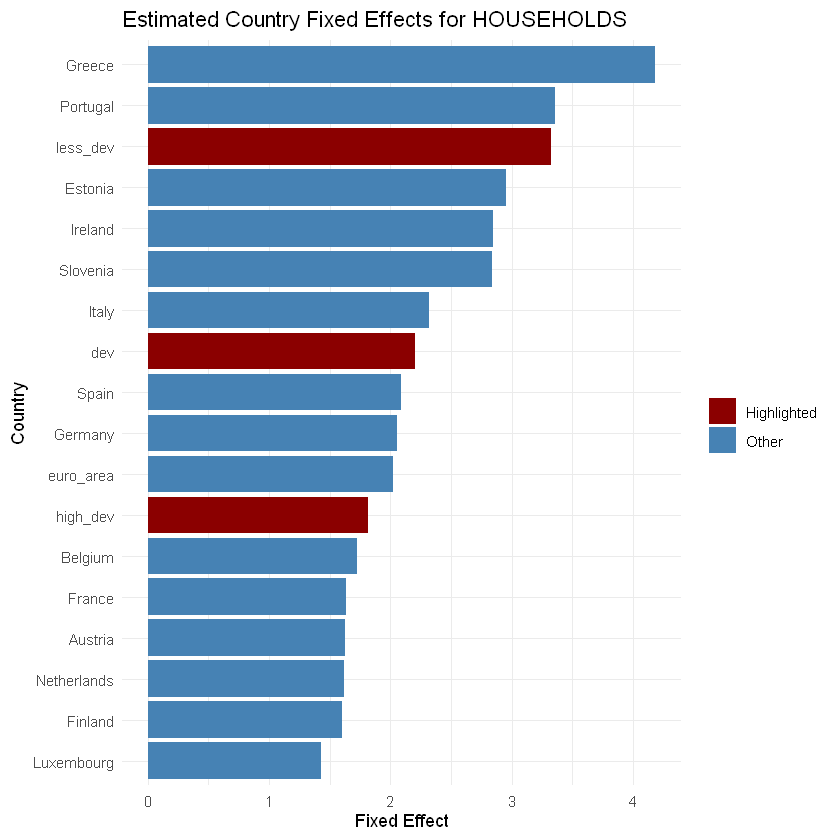

In [85]:
# Extract fixed effects (intercepts) from the model for CORPORATIONS
country_effects <- fixef(fem1_Corp)

# Turn into data frame for plotting
df_effects <- data.frame(Country = names(country_effects),
                         Effect = as.numeric(country_effects))

# Define countries to highlight
highlighted_countries <- c("high_dev", "dev", "less_dev")

# Add a new column for fill color
df_effects$highlight <- ifelse(df_effects$Country %in% highlighted_countries, "Highlighted", "Other")

# Plot with conditional coloring
ggplot(df_effects, aes(x = reorder(Country, Effect), y = Effect, fill = highlight)) +
  geom_col() +
  coord_flip() +
  scale_fill_manual(values = c("Highlighted" = "darkred", "Other" = "steelblue")) +
  labs(title = "Estimated Country Fixed Effects for HOUSEHOLDS",
       x = "Country", y = "Fixed Effect", fill = "") +
  theme_minimal()

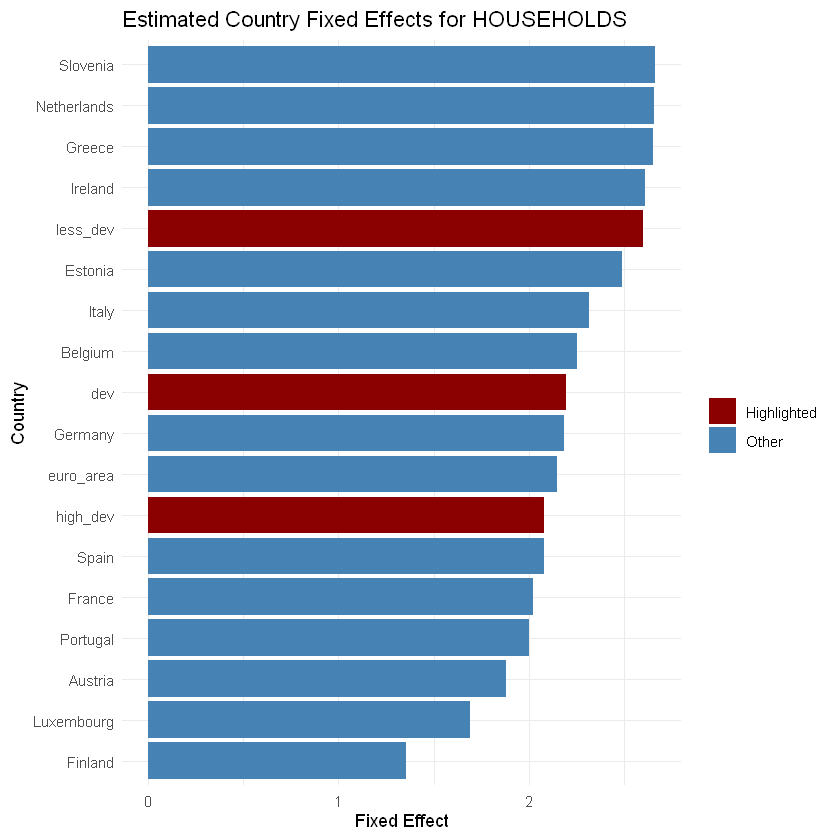

In [86]:
# Extract fixed effects (intercepts) from the model for CORPORATIONS
country_effects <- fixef(fem1_HH)

# Turn into data frame for plotting
df_effects <- data.frame(Country = names(country_effects),
                         Effect = as.numeric(country_effects))

# Define countries to highlight
highlighted_countries <- c("high_dev", "dev", "less_dev")

# Add a new column for fill color
df_effects$highlight <- ifelse(df_effects$Country %in% highlighted_countries, "Highlighted", "Other")

# Plot with conditional coloring
ggplot(df_effects, aes(x = reorder(Country, Effect), y = Effect, fill = highlight)) +
  geom_col() +
  coord_flip() +
  scale_fill_manual(values = c("Highlighted" = "darkred", "Other" = "steelblue")) +
  labs(title = "Estimated Country Fixed Effects for HOUSEHOLDS",
       x = "Country", y = "Fixed Effect", fill = "") +
  theme_minimal()